#### Creating an Interactive Flood Vulnerability Dashboard for New York City Neighborhoods with Panel Library in Python

In [ ]:
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import gdown

In [ ]:
gdown.download('https://www.nyc.gov/assets/doh/downloads/zip/CHS_2009_DOHMH_2010B.zip','CHS_2009_DOHMH_2010B.zip',quiet=True)
gdown.download('https://data.cityofnewyork.us/download/w8eg-8ha6/application/x-zip-compressed','file.zip',quiet=True)

'file.zip'

In [ ]:
!unzip CHS_2009_DOHMH_2010B.zip &> /dev/null
!unzip file.zip &> /dev/null

In [ ]:
nbhds = gpd.read_file("CHS_2009_DOHMH_2010B.shp")

In [ ]:
floodzones = gpd.read_file("NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.gdb")

In [ ]:
rows, cols = 5, 5
storage=[]
for nbhd in nbhds["FIRST_UHF_"].unique():

  if nbhd==None:
    continue

  nbhdstar=nbhds[nbhds['FIRST_UHF_']==nbhd]
  min_x, min_y, max_x, max_y = nbhdstar.total_bounds
  width = (max_x - min_x) / cols
  height = (max_y - min_y) / rows
  counter = 0
  for row in range(rows):
    for col in range(cols):
      counter=counter+1
      left = min_x + col * width
      right = left + width
      top = max_y - row * height
      bottom = top - height
      subsection = shapely.geometry.box(left, bottom, right, top)
      subsection_gdf = gpd.GeoDataFrame({'geometry': [subsection]}, crs=nbhdstar.crs)
      nbhdstarsub=nbhdstar.intersection(subsection)
      ar=nbhdstarsub.to_crs(nbhdstar.crs).area.values[0]
      flood1=nbhdstarsub.intersection(floodzones.iloc[0,3]).area.values[0]
      flood2=nbhdstarsub.intersection(floodzones.iloc[1,3]).area.values[0]
      flood3=nbhdstarsub.intersection(floodzones.iloc[2,3]).area.values[0]

      if ar>0:
        storage.append((nbhd,counter,flood1/ar,flood2/ar,flood3/ar))

In [ ]:
df=pd.DataFrame(storage,columns=['Neighborhood','Section','Nuisance','Deep','High Tide'])
df['Section']=df['Section'].astype(str)

In [ ]:
import panel as pn
import plotly.express as px
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

pn.extension('plotly')

# Create a Panel app
def plot_neighborhood(neighborhood):
    fig = px.line(df[df['Neighborhood'] == neighborhood], x='Section', y=['Nuisance', 'Deep', 'High Tide'])
    fig.update_layout(title='Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise')
    fig.update_layout(yaxis_title='Fraction')
    fig.update_layout(legend_title_text='Flooding Category')
    fig.update_layout(width=600)
    fig.update_layout(title_font=dict(size=14))
    fig.update_layout(legend=dict(orientation="h", x=0.1, y=1.1,font=dict(size=8)))
    return fig

def show_map(neighborhood):
    nbhdstar = nbhds[nbhds['FIRST_UHF_'] == neighborhood]

    rows, cols = 5, 5
    min_x, min_y, max_x, max_y = nbhdstar.total_bounds
    width = (max_x - min_x) / cols
    height = (max_y - min_y) / rows

    # Create an empty GeoDataFrame to store all subsections
    all_subsections_gdf = gpd.GeoDataFrame(columns=['geometry'], crs=nbhdstar.crs)

    # Iterate through rows and columns to create and add subsections to the all_subsections_gdf
    counter = 0
    for row in range(rows):
        for col in range(cols):
            counter += 1
            left = min_x + col * width
            right = left + width
            top = max_y - row * height
            bottom = top - height
            subsection = shapely.geometry.box(left, bottom, right, top)
            subsection_gdf = gpd.GeoDataFrame({'geometry': [subsection]}, crs=nbhdstar.crs)  # Set CRS for each subsection
            all_subsections_gdf = gpd.GeoDataFrame(pd.concat([all_subsections_gdf, subsection_gdf], ignore_index=True))

    # Plot the original GeoDataFrame and all subsections
    fig, ax = plt.subplots(figsize=(2, 2));

    # Plot the original GeoDataFrame
    nbhdstar.plot(ax=ax, color='black', alpha=0.5, edgecolor='k');

    # Plot all subsections
    all_subsections_gdf.plot(ax=ax, color='white', alpha=0.2, edgecolor='k')

    # Annotate each subsection with a counter
    for idx, geom in enumerate(all_subsections_gdf['geometry']):
        x, y = geom.centroid.coords[0]  # Get the centroid of the subsection
        ax.annotate(str(idx + 1), xy=(x, y), ha='center', va='center', fontsize=10);
    ax.set_aspect('equal')
    ax.set_axis_off();
    #plt.title(neighborhood)
    show = False
    plt.close(fig)
    return fig


neighborhood_dropdown = pn.widgets.Select(name='', options=sorted(df['Neighborhood'].unique().tolist()))
plot = pn.panel(plot_neighborhood(neighborhood_dropdown.value))

@pn.depends(neighborhood=neighborhood_dropdown.param.value)
def update_plot(neighborhood):
    return plot_neighborhood(neighborhood)

@pn.depends(neighborhood=neighborhood_dropdown.param.value)
def update_map(neighborhood):
    return show_map(neighborhood)

dashboard = pn.Column(neighborhood_dropdown, pn.Row(update_plot, update_map))



#### &nbsp;
***

Column
    [0] Select(options=['Bayside - Meadows', ...], value='Bensonhurst - Bay Ridge')
    [1] Row
        [0] ParamFunction(function, _pane=Plotly, defer_load=False)
        [1] ParamFunction(function, _pane=Matplotlib, defer_load=False)
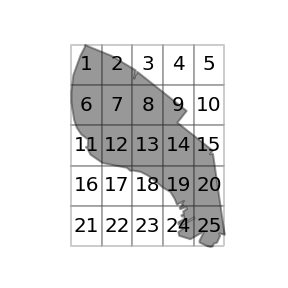

In [14]:
dashboard.servable()